In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os

import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud
from textblob import Word



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [169]:
#Mount google drive 
from google.colab import drive
drive.mount('/content/drive')

#directory path where the age data set is stored --TO MODIFY
dir_path = '/content/drive/MyDrive/Summer 2022/'
#file name --TO MODIFY
file_name = 'AgeDataset-V1.csv'
os.listdir(dir_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['AgeDataset-V1.csv']

In [170]:
dataset = pd.read_csv(dir_path + file_name)
#dataset.head(20)
df = dataset
df.head()

,Id,Name,Short description,Gender,Country,Occupation,Birth year,Death year,Manner of death,Age of death
0,Q23,George Washington,1st president of the United States (1732–1799),Male,United States of America; Kingdom of Great Bri...,Politician,1732,1799.0,natural causes,67.0
1,Q42,Douglas Adams,English writer and humorist,Male,United Kingdom,Artist,1952,2001.0,natural causes,49.0
2,Q91,Abraham Lincoln,16th president of the United States (1809-1865),Male,United States of America,Politician,1809,1865.0,homicide,56.0
3,Q254,Wolfgang Amadeus Mozart,Austrian composer of the Classical period,Male,Archduchy of Austria; Archbishopric of Salzburg,Artist,1756,1791.0,NaN,35.0
4,Q255,Ludwig van Beethoven,German classical and romantic composer,Male,Holy Roman Empire; Austrian Empire,Artist,1770,1827.0,NaN,57.0


Data Cleaning

In [171]:
idx = df.index[df['Death year'].isnull()]
print(df.shape)
df = df.drop(index=idx)
print(df.shape)
idx = df.index[df['Birth year']>1700]
df = df.drop(index=idx)
print(df.shape)

(1223009, 10)
(1223008, 10)
(108991, 10)


In [172]:
occ_df = df
occ_df['Occupation'] = occ_df['Occupation'].str.split(';').str[0].str.strip()
occ_df.head()

,Id,Name,Short description,Gender,Country,Occupation,Birth year,Death year,Manner of death,Age of death
8,Q297,Diego Velázquez,Spanish painter (1599-1660),Male,Spain,Artist,1599,1660.0,NaN,61.0
9,Q301,El Greco,"Greek painter, sculptor and architect",Male,Spain; Republic of Venice,Artist,1541,1614.0,NaN,73.0
11,Q307,Galileo Galilei,"Italian mathematician, physicist, philosopher ...",Male,Grand Duchy of Tuscany; Duchy of Florence,Astronomer,1564,1642.0,NaN,78.0
13,Q346,Louis IX of France,king of France,Male,France,Ruler,1214,1270.0,natural causes,56.0
15,Q353,Blanche of Castile,"Spanish princess and saint, queen consort of F...",Female,Kingdom of Castile,Regent,1188,1252.0,NaN,64.0


In [173]:
#Removing data objects with Null values for Occupation
idx = occ_df.index[occ_df['Occupation'].isnull()]
print(occ_df.shape)
occ_df = occ_df.drop(index=idx)
print(occ_df.shape)

(108991, 10)
(77394, 10)


In [178]:
#Removing data objects with Null values for Short Description
idx = occ_df.index[occ_df['Short description'].isnull()]
print(occ_df.shape)
occ_df = occ_df.drop(index=idx)
print(occ_df.shape)

(77394, 10)
(76062, 10)


In [179]:
sd_df = occ_df[['Occupation','Short description']]
print(sd_df.shape)
sd_df.head()

(76062, 2)


,Occupation,Short description
8,Artist,Spanish painter (1599-1660)
9,Artist,"Greek painter, sculptor and architect"
11,Astronomer,"Italian mathematician, physicist, philosopher ..."
13,Ruler,king of France
15,Regent,"Spanish princess and saint, queen consort of F..."


In [180]:
sd_df.isna().sum()

Occupation           0
Short description    0
dtype: int64

In [143]:
# #sd_df.dropna(axis=0, subset=['Short description'], inplace=True)
# sd_df = sd_df.dropna()
# sd_df.isna().sum()

Occupation           0
Short description    0
dtype: int64

Preprocessing text data


In [181]:
test = sd_df

In [182]:
## Lower case
test['Short description'] = test['Short description'].apply(lambda x: " ".join(x.lower()for x in x.split()))
## remove tabulation and punctuation
test['Short description'] = test['Short description'].str.replace('[^\w\s]',' ')
## digits
test['Short description'] = test['Short description'].str.replace('\d+', '')

#remove stop words
stop = stopwords.words('english')
test['Short description'] = test['Short description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

## lemmatization
test['Short description'] = test['Short description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

print("Preprocessed data: \n")
print(test.head())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launch

Preprocessed data: 

    Occupation                                  Short description
8       Artist                                    spanish painter
9       Artist                   greek painter sculptor architect
11  Astronomer  italian mathematician physicist philosopher as...
13       Ruler                                        king france
15      Regent        spanish princess saint queen consort france


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


# Visualize data

In [183]:
# jda stands for job description aggregated
jda = test.groupby(['Occupation']).sum().reset_index()
print("Aggregated job descriptions: \n")
print(jda)

Aggregated job descriptions: 

                    Occupation  \
0                       Abbess   
1                         Abbé   
2                     Academic   
3                   Accountant   
4                      Acolyte   
..                         ...   
726  Woodwind instrument maker   
727             Writing master   
728                Xylographer   
729            Zemleprokhodtsy   
730                      Župan   

                                     Short description  
0    member house habsburgenglish princessabbess ro...  
1    founder seminary saint sulpice montrealfrench ...  
2    spanish noble academicenglish scholarconfessor...  
3    royal governor la floridaenglish accountant au...  
4                                              acoliet  
..                                                 ...  
726                   german woodwind instrument maker  
727                             english writing master  
728                                  german pri


*** ['Politician'] ***



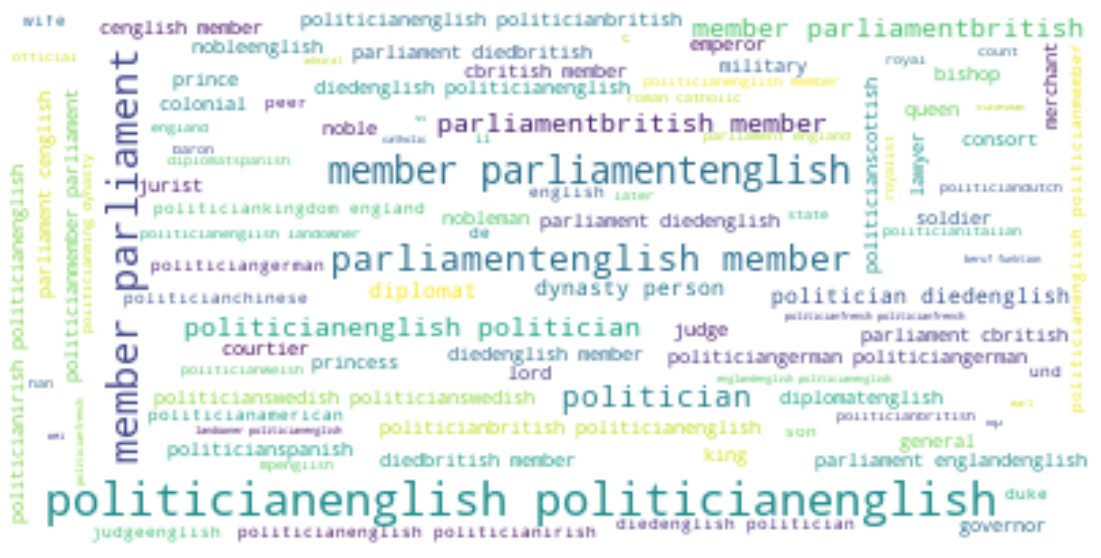

In [184]:
    f, ax = plt.subplots(figsize=(20, 10))
    # Start with one review:
    text = jda['Short description'][jda.Occupation == 'Politician'].iloc[0]
    # Create and generate a word cloud image:
    wordcloud = WordCloud(background_color="white", max_words=100).generate(text)
    print("\n***",job,"***\n")
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [185]:
#filtered_words = [word for word in text.split() if word not in stopwords]
filtered_words = text.split()
counted_words = collections.Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(40):
    words.append(letter)
    counts.append(count)

<BarContainer object of 40 artists>

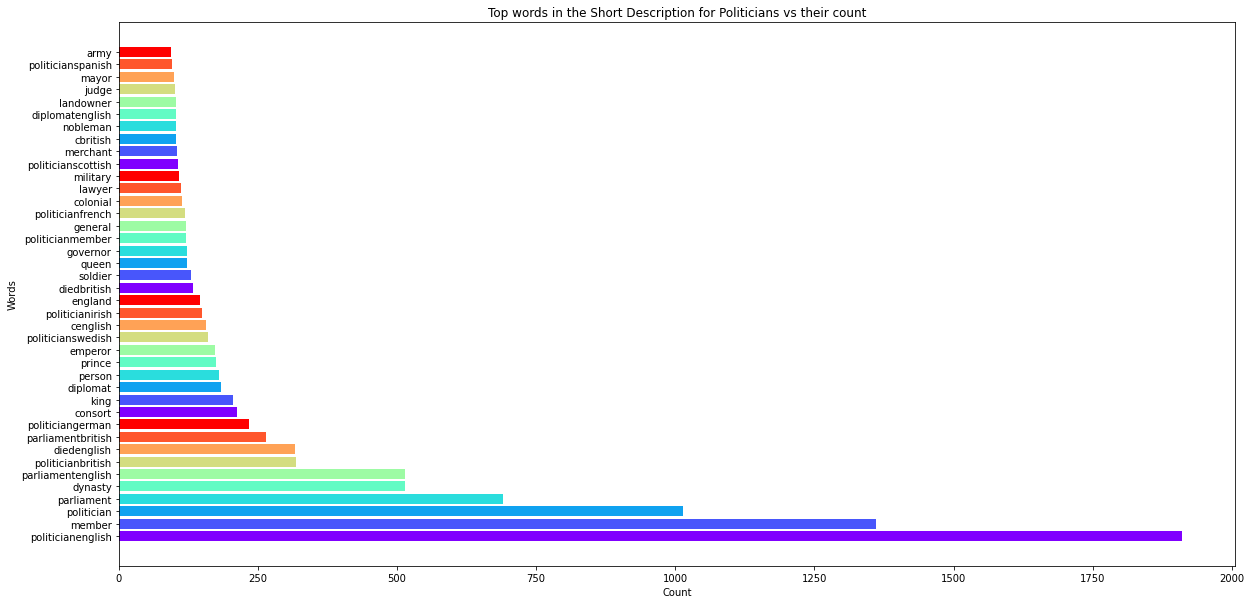

In [186]:
import matplotlib.cm as cm
from matplotlib import rcParams

colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 20, 10

plt.title('Top words in the Short Description for Politicians vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

In [187]:
pol_df = occ_df.loc[occ_df['Occupation'] == 'Politician']
pol_df.head()

,Id,Name,Short description,Gender,Country,Occupation,Birth year,Death year,Manner of death,Age of death
29,Q498,"Ulrich Frédéric Woldemar, Comte de Lowendal",German-born French soldier and statesmen (1700...,Male,Denmark; Russian Empire; Kingdom of France; El...,Politician,1700,1755.0,NaN,55.0
181,Q1786,Jan I Carondelet,Burgundian jurist and politician,Male,Burgundian Netherlands,Politician,1428,1502.0,NaN,74.0
183,Q1791,Jan II Carondelet,"Burgundian cleric, politician, jurist, and adv...",Male,Burgundian Netherlands,Politician,1469,1544.0,NaN,75.0
184,Q1798,Ferry Carondelet,"Habsburg diplomat, advisor, and abbot (1473-1528)",Male,NaN,Politician,1473,1528.0,NaN,55.0
336,Q4735,John Hamilton,Scottish nobleman (1537-1604),Male,Kingdom of Scotland,Politician,1537,1604.0,NaN,67.0


In [164]:
# #Removing unecessary/ redundant words in the Short Description.
# contain_values = pol_df[~pol_df['Short description'].str.contains('politician' , na=False)]
# contain_values.head()

# does_contain_value = contain_values[contain_values['Short description'].str.contains('politicianenglish' , na=False)]
# does_contain_value.head()

In [188]:
contain_values_king = pol_df[pol_df['Short description'].str.contains('king' , na=False)]
contain_values_king.describe()

,Birth year,Death year,Age of death
count,158.000000,158.000000,158.000000
mean,869.892405,920.765823,50.873418
std,731.050371,729.556432,19.297118
min,-1800.000000,-1734.000000,13.000000
25%,477.000000,520.000000,37.250000
50%,1057.000000,1114.000000,49.000000
75%,1468.000000,1499.250000,62.750000
max,1700.000000,1770.000000,94.000000


In [189]:
contain_values_gov = pol_df[pol_df['Short description'].str.contains('governor' , na=False)]
contain_values_gov.describe()

,Birth year,Death year,Age of death
count,167.000000,167.000000,167.000000
mean,1581.652695,1643.928144,62.275449
std,212.994511,212.757302,15.952363
min,150.000000,180.000000,15.000000
25%,1598.500000,1656.500000,50.500000
50%,1637.000000,1695.000000,63.000000
75%,1663.500000,1728.500000,73.500000
max,1700.000000,1778.000000,99.000000


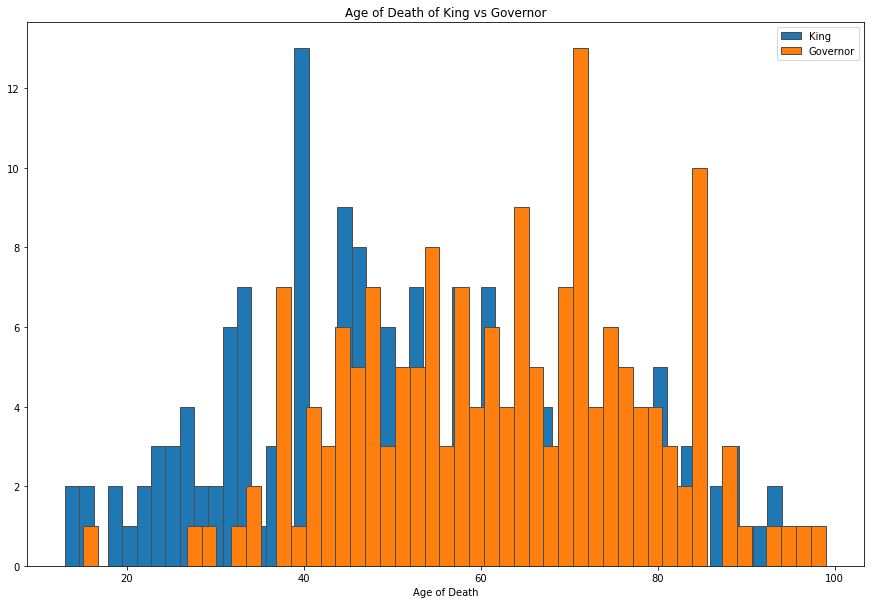

In [211]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas

fig = plt.figure(figsize = (15,10))
contain_values_king ['Age of death'].hist(bins=50, edgecolor=".3", label=['King'])
contain_values_gov['Age of death'].hist(bins=50, edgecolor=".3", label=['Governor'])
plt.xlabel('Age of Death')
#plt.ylabel('Count')
plt.title('Age of Death of King vs Governor')
plt.grid(b=None)
plt.legend()